# **Computer Vision**

What is computer vision?


*   Giving computers the power of vision.
*   Seeks to automate tasks that the human visual system can do.

![img1.jpg](https://miro.medium.com/max/1600/1*8gmgaAkFdI-9OHY5cA93xQ.png)




### **What is an Image?**

Generally, we can consider an image as a matrix whose elements are numbers between 0 and 255. The size of this matrix is (image height) x (image width) x (# of image channels). A grayscale image has 1 channel where a color image has 3 channels (for RGB).

#### **Grayscale image**
Each value mentioned above is unint8 (a 8-bit number). i.e, it can take values between 0-255. These values correspond to the shade of that particular parameter. 0 for minimum and 255 for maximum.
Grayscale image

A pixel having the value 0 implies it is black and the pixel having value 255 implies that it is white. The values inbetween correspond to shades inbetween.

![](https://i.imgur.com/p60dsOJ.png)

#### **RGB image**

Each pixel has three channels, one for each colour.

R : 0-255.

G : 0-255.

B : 0-255.

Each number between 0-255 corresponds to a shade of that corresponding color. All 3 channels being 0 makes the pixel black while all 3 channels being 255 makes the pixel white.
![](https://imgur.com/UyR0VS7.jpg=150x150)

There are lots of other colour spaces which are used to represent a coloured image which we won't discuss in detail. These include:

- CIE 1931 XYZ : It was the first attempt to produce a color space based on measurements of human color perception
- HSV (Hue, Saturation and value)
- CMYK (Cyan Yellow Magenta Key) is a subtractive model used especially in printing.

### Importing libraries

Let's start by importing all of the modules we'll need. The main ones we need to import are:
- torch for general PyTorch functionality
- torch.nn and torch.nn.functional for neural network based functions
- torch.optim for our optimizer which will update the parameters of our neural network
- torch.utils.data for handling the dataset
- torchvision.transforms for data augmentation
- torchvision.datasets for loading the dataset
- sklearn's metrics for visualizing a confusion matrix
- sklearn's decomposition and manifold for visualizing the neural network's representations in two dimensions
- matplotlib for plotting

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import random
import time

We set the random seed so all of our experiments can be reproduced.


In [6]:
SEED = 1111

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### CIFAR10 Dataset

So first off we will be using the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 

CIFAR10 consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. 
![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/cifar10.png?raw=1)

The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. 

In [7]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [8]:
trainset.data.shape

(50000, 32, 32, 3)

In [10]:
trainset.data.mean(axis=(0,1,2))

array([125.30691805, 122.95039414, 113.86538318])

###Transforms
A `transform` states how our data should be augmented and processed. Data augmentation involves manipulating the available training data in a way that artifically creates more training examples. We use `transforms.Compose` to built a list of transformations that will be applied to the image. 

The transforms we use are:
- `ToTensor()` - this converts the image from a PIL image into a PyTorch tensor.
- `RandomHorizontalFlip(p = 0.5)`. This transform with a specified probability flips the image horizontally. So an image of a horse facing to the right will be flipped so it will face to the left.
- `Normalize(mean, std)` - this subtracts the mean and divides by the standard deviations given. 

Some other ones which can be used 
- `RandomCrop` - this first adds `padding` around our image, 2 pixels here, to artifically make it bigger, before taking a random `28x28` square crop of the image.

    ```transforms.RandomCrop(32, padding = 2)```
- `RandomRotation` - randomly rotates the image between `(-x, +x)` degrees, where we can set `x`


See the Torchvision documentation for [transforms that should be applied to PIL images](https://pytorch.org/docs/stable/torchvision/transforms.html#transforms-on-pil-image) and [transforms that should be applied on tensors](https://pytorch.org/docs/stable/torchvision/transforms.html#transforms-on-torch-tensor).

We have two lists of transforms, a train and a test transform. The train transforms are to artificially create more examples for our model to train on. We do not augment our test data in the same way as we want a consistent set of examples to evaluate our final model on. The test data, however, should still be normalized.

###Normalization

Normalize does the following for each channel:

$(image = (image - mean) / std)$

The parameters mean, std are passed as 0.5 in our case.
This will normalize the image to the range [-1,1]. 

For example, the minimum value 0 will be converted to $(0-0.5)/0.5=-1$,   
the maximum value of 1 will be converted to $(1-0.5)/0.5=1$.


In [19]:
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
train_transform = transforms.Compose([
                    transforms.Resize([32, 32]),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                    ])
test_transform = transforms.Compose([
                    transforms.Resize([32, 32]),
                    transforms.ToTensor(),
                    transforms.Normalize(mean,std),
                    ])


train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

classes = train_data.classes


Files already downloaded and verified
Files already downloaded and verified


In [20]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

###Validation Set

The validation set is used to evaluate a given model, but this is for frequent evaluation. The input from this data to fine-tune the model hyperparameters.

Hence the model occasionally sees this data, but never does it 'Learn' from this. We use the validation set results, and update higher level hyperparameters. So the validation set affects a model, but only indirectly

In [21]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [22]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [31]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [32]:
trainset[0]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F95696C9310>, 6)

In [33]:
classes = test_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

We get both the images and the labels from the training set and convert the labels, which are originally stored as integers, into their human readable class by using the data's `classes` dictionary.

When we plot them we see lots of warnings. This is because `matplotlib` is expecting the values of every pixel to be between $[0, 1]$, however our normalization will cause them to be outside this range. By default `matplotlib` will then clip these values into the $[0,1]$ range. This clipping causes all of the images to look a bit weird - all of the colors are oversaturated.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

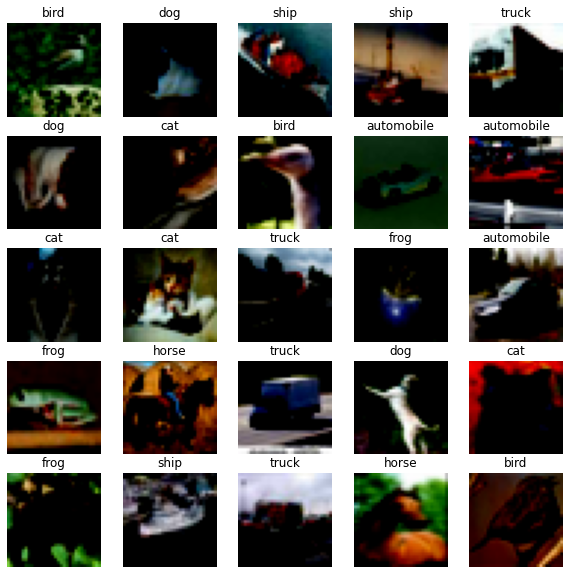

In [34]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

plot_images(images, labels, classes)

A solution to this is to *renormalize* the images so each pixel is between $[0,1]$. This is done by clipping the pixel values between the maximum and minimum within an image and then scaling each pixel between $[0,1]$ using these maximum and minimums. 

As we can see the images below look a lot more like we were expecting.

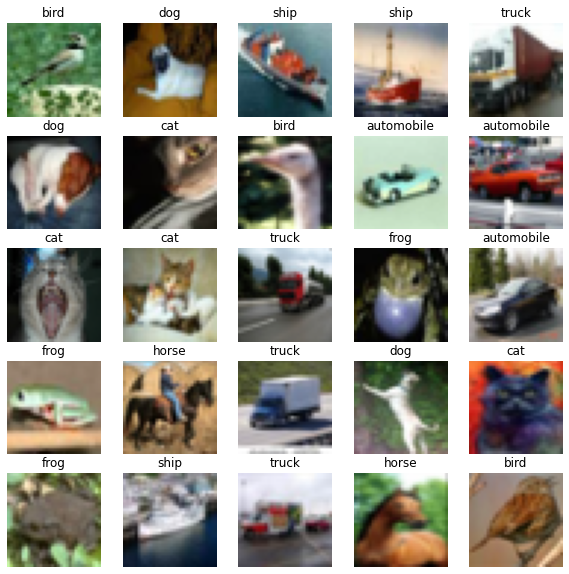

In [35]:
plot_images(images, labels, classes, normalize = True)

In [36]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

The final bit of the data processing is creating the iterators.

Generally, when using a GPU, a larger batch size means our model trains faster.

In [37]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [38]:
a = iter(train_iterator).next()

In [39]:
a[0].shape

torch.Size([256, 3, 32, 32])

In [40]:
a[1].shape

torch.Size([256])

### Convolutions

Each convolution operation has a kernel which could be any matrix smaller than the original image in height and width. Each kernel is useful for a specific task, such as sharpening, blurring, edge detection, and more. 

#### Intution on how convolutions work
![](https://miro.medium.com/max/700/1*Fw-ehcNBR9byHtho-Rxbtw.gif)

The output of convolution might violate the input range of [0-255]. Hence, any value above 255 is taken as 255 and the pixel is made white in colour.


One of the reasons that CNNs have been so successful is their ability to build up complex filters by composing more simple filters. For example, imagine a 5 layer CNN that has been trained to detect faces. The first 4 layers are convolutional and the last layer is fully-connected and outputs the final prediction (is there a face or not). We might find that the filters in each convolution layer pick out the following features:

1. lines (horizontal, vertical, diagonal), and colour gradients,
2. corners, circles and other simple shapes, and simple textures,
3. noses, mouths, and eyes,
4. whole faces.

The neural net has learned to pick out complex objects like facial features and even whole faces! The reason for this is that each successive layer can combine the filters from the previous layer to detect more and more sophisticated features. The following diagram (adapted from [this paper](http://web.eecs.umich.edu/~honglak/icml09-ConvolutionalDeepBeliefNetworks.pdf)) shows some really cool examples of this kind of behaviour. The lower level features (shown above) detect noses, eyes, and mouths, in the case of faces, and wheels, doors, and windows, for cars. The higher level features are then able to detect whole faces and cars.

![Imgur](https://i.imgur.com/653uIty.jpg)

The diagrams on page 7 of [this classic paper](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf) show more examples of this phenomena and are definitely worth checking out!

In [41]:
def plot_filter(images, filter, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
    filter = filter.repeat(3, 3, 1, 1)
    
    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    images = images.permute(0, 2, 3, 1)
    filtered_images = filtered_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize = (25, 5))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i]

        if normalize:
            image = normalize_image(image)
        
        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title(f'Filtered')
        ax.axis('off');

The filters are still 2-dimensional but they are expanded to a depth of three dimensions inside the `plot_filter` function.

Below is a filter which detects horizontal lines.

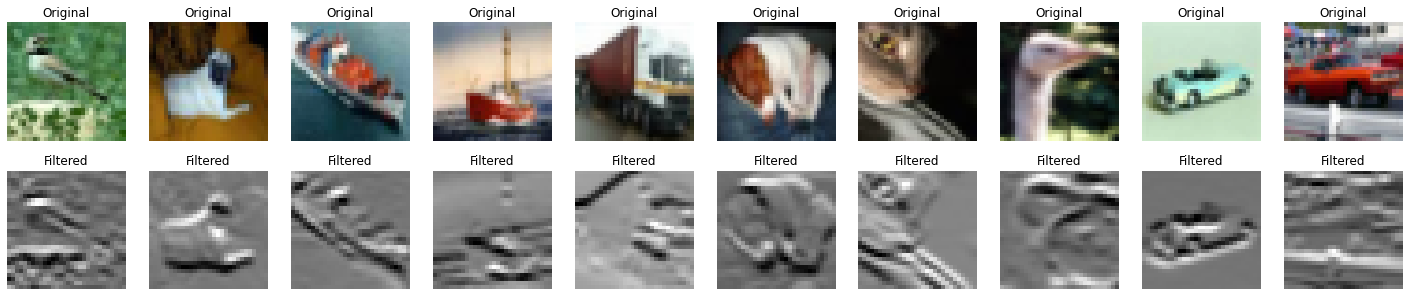

In [42]:
N_IMAGES = 10

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

Here's a filter that detects vertical lines.

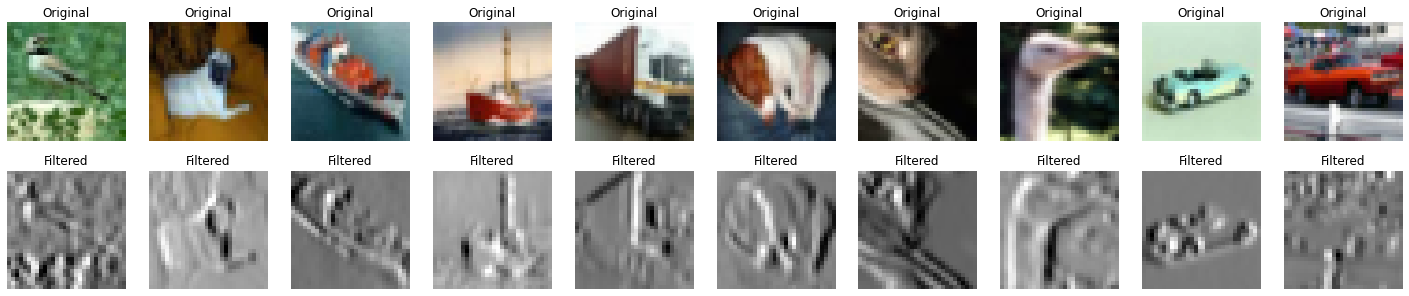

In [43]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

### (Max) Pooling
A pooling layer reduces the spatial size of the representation. There are different reasons why we may want to do this. One is to reduce the number of parameters in the network. Imagine a convnet for the MNIST dataset. If the feature tensor produced by the final conv/pool/relu layer was say, of size 20x20 and had 100 feature channels, the final dense layer would have 20x20x100x10=400k parameters. However, if we down-sampled that layer to a 4x4 spatial size, we would have only 20k parameters. A big difference!

Another reason is that we want later features (deeper in the network) to have larger *receptive fields* (input regions that they look at), in order to represent bigger objects and object parts for instance. In particular, pooling stride gives later features much larger receptive fields so that they can effectively combine smaller features together.

A pooling layer has no trainable parameters. It applies some 2-D aggregation operation (usually a max(), but others like average() may also be used) to regions of the input volume. This is done independently for each depth dimension of the input. For example, a 2x2 max pooling operation with a stride of 2, downsamples every depth slice of the input by 2 along both the width and height.

The hyper-parameters of a pooling layer are as follows:
* **Pool Size** defines how many values are aggregated together.
* **Stride** defines the number of pixels by which we move the pooling filter when sliding it along the input. Typically this value would be equal to the pool size.
* **Padding** refers to the addition of 0-value pixels to the edges of the input volume along the width and height dimensions. In Tensorflow you can set this to "VALID", which essentially does no padding or "SAME" which pads the input such that the output width and height are the same as the input.

#### Question
Do 2x2 max-pooling by hand, with a stride of 2, and padding 0, on the following 2D input. What is the size of the output?

\begin{bmatrix}
  9 & 5 & 4 & 5 & 6 & 4 \\
  6 & 6 & 3 & 5 & 8 & 2 \\
  4 & 6 & 9 & 1 & 3 & 6 \\
  9 & 7 & 1 & 5 & 8 & 1 \\
  4 & 9 & 9 & 5 & 7 & 3 \\
  7 & 3 & 6 & 4 & 9 & 1 
\end{bmatrix}


Reveal the cell below by double-clicking and running it, to check your answer when you're done!

In [ ]:
X = np.array([[9, 5, 4, 5, 6, 4],
              [6, 6, 3, 5, 8, 2],
              [4, 6, 9, 1, 3, 6],
              [9, 7, 1, 5, 8, 1],
              [4, 9, 9, 5, 7, 3],
              [7, 3, 6, 4, 9, 1]])
X = torch.Tensor(X).unsqueeze(0)


m = nn.MaxPool2d((2,2), stride=2, padding=0,)
Y = m(X)
Y

tensor([[[9., 5., 8.],
         [9., 9., 8.],
         [9., 9., 9.]]])

###Receptive Fields

Earlier we mentioned that one reason to do pooling is to increase the sizes of the receptive fields of our features. Let's take a closer look at what we meant by this. 

The diagram below shows the effective receptive field of one output "neuron" in each layer of a few simple networks. What the diagram tells us is how many of the input values have an effect on each output value.

We can see that in the first two examples, with single convolutional layers, the receptive field is simply equal to the kernel size. 

However, the next two examples are a little more interesting. Here we have drastically increased the receptive field size, without a large increase in the number of parameters, by stacking convolution and pooling layers. The interesting thing here is that by using a pooling layer we increased our receptive field size by a much smaller cost (in the number of parameters) than if we'd simply increased the kernel sizes of our convolution layers.

You can read more about receptive fields [here](https://medium.com/mlreview/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807).


![Receptive Fields](https://i.imgur.com/TjxEsG4.png)


In [ ]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1), #in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2), #kernel_size
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 192, 3, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace = True),
            nn.Conv2d(192, 384, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace = True)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [44]:
class NeuralNet(nn.Module):
    def __init__(self, output_dim):
        super(NeuralNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.1)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.3)
        )

        self.fc = nn.Linear(128, output_dim)  # number of classes =10

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.conv5(x)
        x = self.conv6(x)


        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        h = x.view(x.shape[0], -1)

        x = self.fc(h)
        return x, h

Now we create an instance of our model with the desired amount of classes.

In [45]:
OUTPUT_DIM = 10

# model = AlexNet(OUTPUT_DIM)
model = NeuralNet(OUTPUT_DIM)

In [82]:
print(model)

NeuralNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=

###Torch summary
Keras has a neat API to view the visualization of the model which is very helpful while debugging your network. Here is a barebone code to try and mimic the same in PyTorch. The aim is to provide information complementary to, what is not provided by print(your_model) in PyTorch. Github repo https://github.com/sksq96/pytorch-summary

```
from torchsummary import summary
summary(your_model, input_size=(channels, H, W))
```

![](https://i.stack.imgur.com/2sj2X.png)

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)

cuda


In [50]:
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
         Dropout2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]          36,928
             ReLU-13           [-1, 64, 16, 16]               0
      BatchNorm2d-14           [-1, 64,

Here we define the optimizer that we use and also the loss function we want to use, the device we'll use and place our model and criterion on to our device.

In [47]:
LR = 1e-3
optimizer = optim.Adam(model.parameters(), lr = LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

cuda


The rest of the notebook is pretty similar to common training workflows.

We define a function to calculate accuracy...

In [51]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...and a function to implement our training loop.

As we are using dropout we need to make sure to "turn it on" when training by using `model.train()`.

In [52]:
def train(model, dataset, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in dataset:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(dataset), epoch_acc / len(dataset)

We also define an evaluation loop, making sure to "turn off" dropout with `model.eval()`.

In [53]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [54]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

So finally lets start training :D

In [55]:
EPOCHS = 25

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 1.473 | Train Acc: 46.09%
	 Val. Loss: 1.142 |  Val. Acc: 58.47%
Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 1.078 | Train Acc: 61.74%
	 Val. Loss: 0.930 |  Val. Acc: 66.94%
Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 0.917 | Train Acc: 67.77%
	 Val. Loss: 0.803 |  Val. Acc: 71.06%
Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 0.800 | Train Acc: 71.98%
	 Val. Loss: 0.749 |  Val. Acc: 73.26%
Epoch: 05 | Epoch Time: 0m 19s
	Train Loss: 0.719 | Train Acc: 75.21%
	 Val. Loss: 0.656 |  Val. Acc: 76.53%
Epoch: 06 | Epoch Time: 0m 19s
	Train Loss: 0.654 | Train Acc: 77.44%
	 Val. Loss: 0.607 |  Val. Acc: 78.48%
Epoch: 07 | Epoch Time: 0m 19s
	Train Loss: 0.609 | Train Acc: 79.19%
	 Val. Loss: 0.571 |  Val. Acc: 80.51%
Epoch: 08 | Epoch Time: 0m 19s
	Train Loss: 0.568 | Train Acc: 80.30%
	 Val. Loss: 0.539 |  Val. Acc: 81.03%
Epoch: 09 | Epoch Time: 0m 19s
	Train Loss: 0.534 | Train Acc: 81.70%
	 Val. Loss: 0.518 |  Val. Acc: 82.03%
Epoch: 10 | Epoch T

In [ ]:
model = NeuralNet(OUTPUT_DIM)
model = model.cuda()
model.load_state_dict(torch.load('tut-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.428 | Test Acc: 86.06%


### Examining the Model

We will now be doing some probing into our model : 
- plotting a confusion matrix
- plotting the most confident incorrect predictions
- using PCA and t-SNE, and viewing the learned weights of our model.

First, we'll collect all of the predictions.

In [56]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [57]:
images, labels, probs = get_predictions(model, test_iterator, device)

In [58]:
probs[0]

tensor([5.7095e-04, 1.1041e-04, 2.5250e-04, 7.9935e-01, 7.3543e-06, 1.8668e-01,
        1.0796e-02, 2.1133e-03, 1.2342e-05, 1.1278e-04])

In [59]:
pred_labels = torch.argmax(probs, 1)

In [60]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

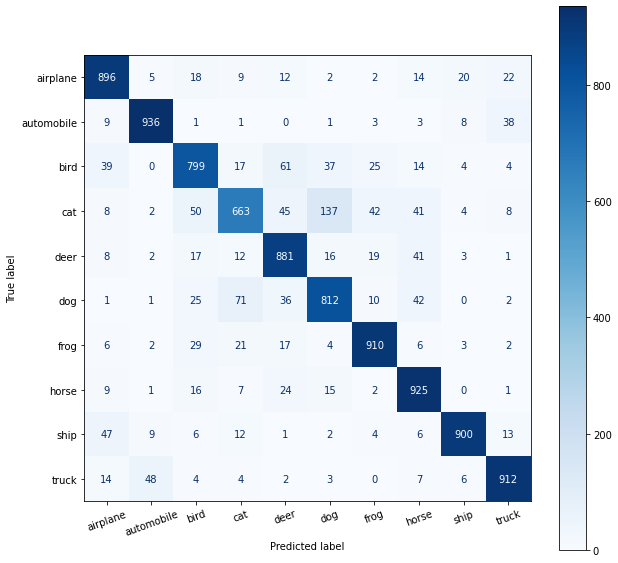

In [61]:
plot_confusion_matrix(labels, pred_labels, classes) 

We can now find which predictions were correct and then sort the incorrect predictions in descending order of their confidence.

In [62]:
corrects = torch.eq(labels, pred_labels)

In [63]:
corrects.unique(return_counts=True)

(tensor([False,  True]), tensor([1366, 8634]))

In [64]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [65]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

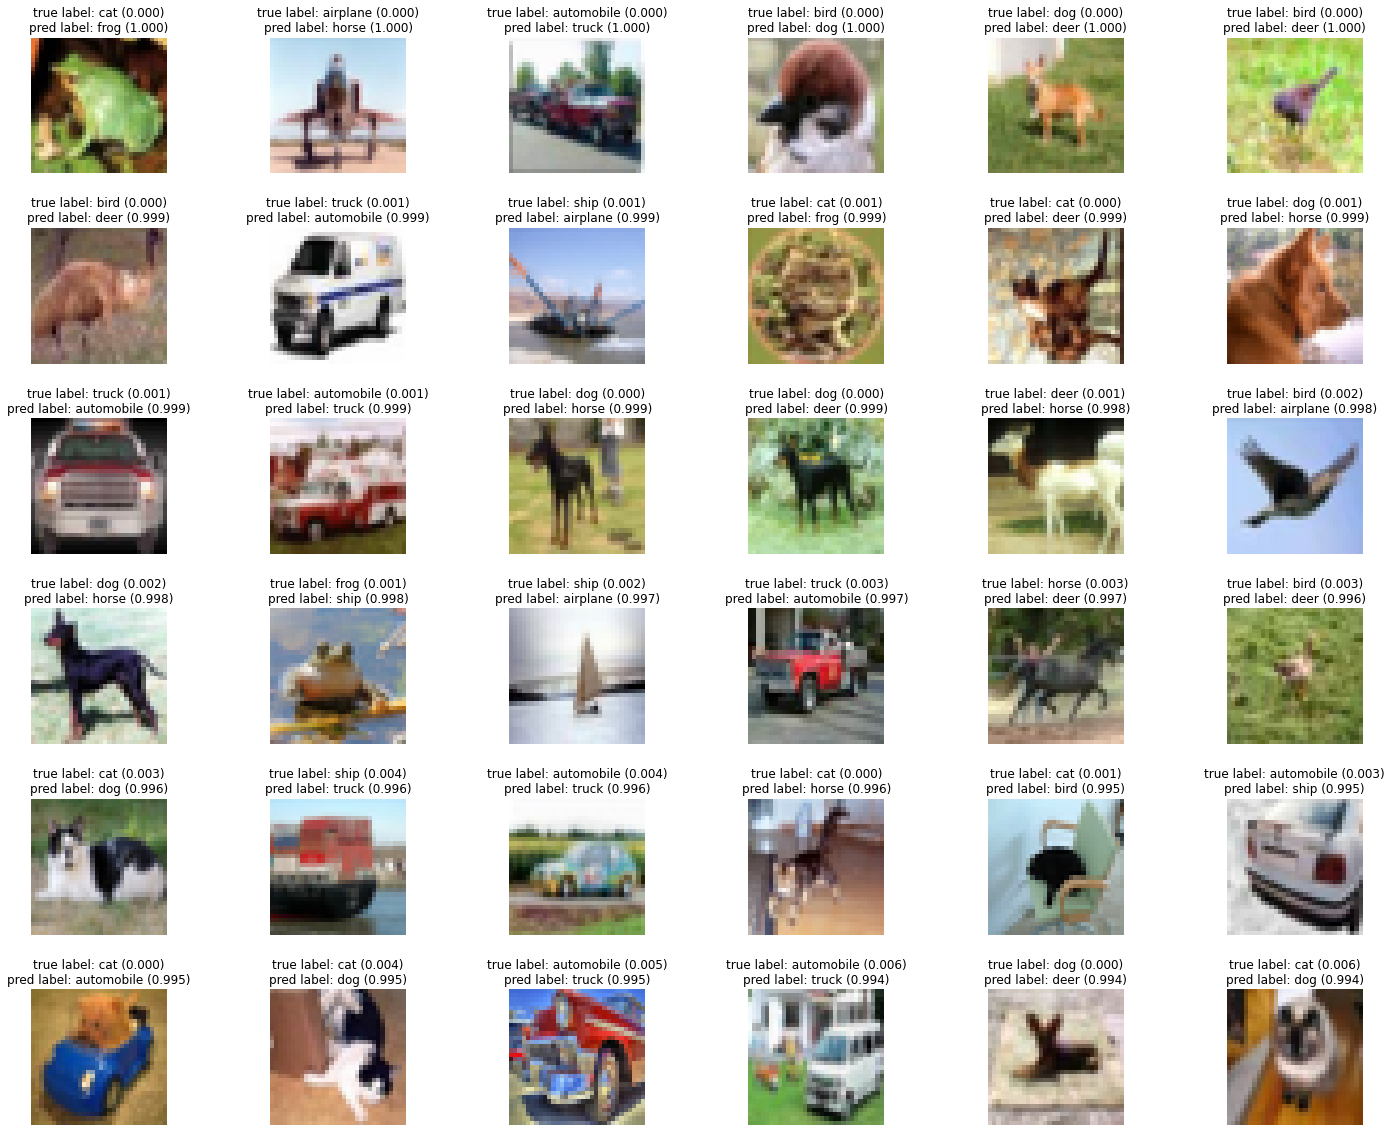

In [66]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [67]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    intermediates = torch.cat(intermediates, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, intermediates, labels

outputs, intermediates, labels = get_representations(model, train_iterator, device)

In [68]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [69]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

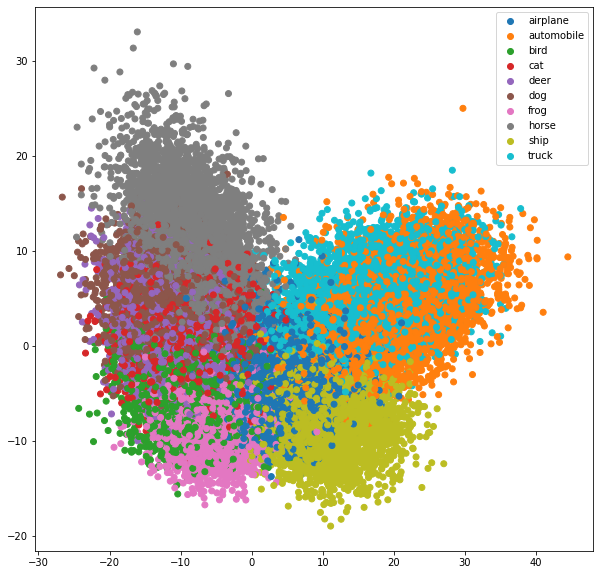

In [70]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

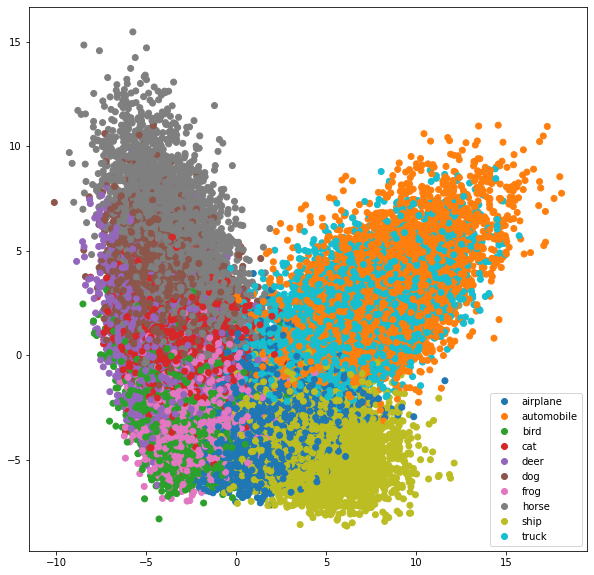

In [ ]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels, classes)

###Occlusion sensitivity

In [71]:
def occlusion_map(img, net, N):
    img_h, img_w = img.shape[1:]
    conf_arr = np.zeros((img_h,img_w))

    n = (N-1)//2
    for i in range(img_w):
        for j in range(img_h):
            # Create a copy of the input img and calulate window size to grey out
            new_img = img.detach().clone()
            x1 = max(0,i-n)
            x2 = min(i+n+1,img_w)
            y1 = max(0,j-n)
            y2 = min(j+n+1,img_h)
            # Grey out the part of input img
            new_img[:,y1:y2,x1:x2] = 1

            ## Run the model through the new occluded image 
            y_pred, _ = model(new_img.unsqueeze(0).cuda())
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)
            top_prob = y_prob.max()
            conf_arr[j,i] = top_prob
    return conf_arr


In [72]:
N = 11

images = [image for image, label in [test_data[i] for i in range(15)]]
img = images[2]

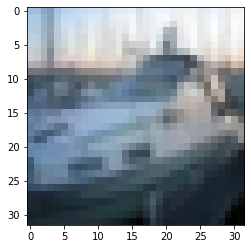

In [73]:
plt.imshow(normalize_image(img.permute(1, 2, 0)))

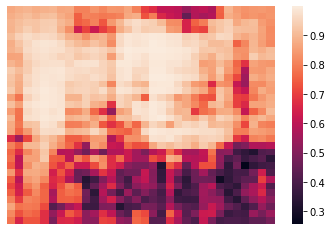

In [74]:
conf_arr = occlusion_map(img, model, N)
imgplot = sns.heatmap(conf_arr, xticklabels=False, yticklabels=False)
figure = imgplot.get_figure()

On a bigger dataset, the ImageNet dataset
![](https://i.imgur.com/Uwa5ICl.png)

###Filter visualization

In [75]:
def plot_filters_multi_channel(t):
    
    #Number of kernels
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()
  
def plot_weights(model):
    #extracting the model features at the particular layer number
    weight_tensor = model.conv1[0].weight.data
    weight_tensor = weight_tensor.cpu()
    if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
    else:
        print("Can only plot weights with three channels with single channel = False")

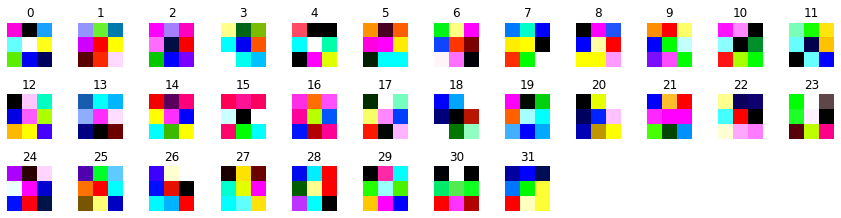

In [76]:
plot_weights(model)

From the filters above you can see that we cant conclude as much as we could because of the smaller filter size and small image size present in the cifar10 dataset. Lets look at the filters of a popular convolutional network architecture called ALexNet, which is trained on the higher quality of images in ImageNet Dataset.

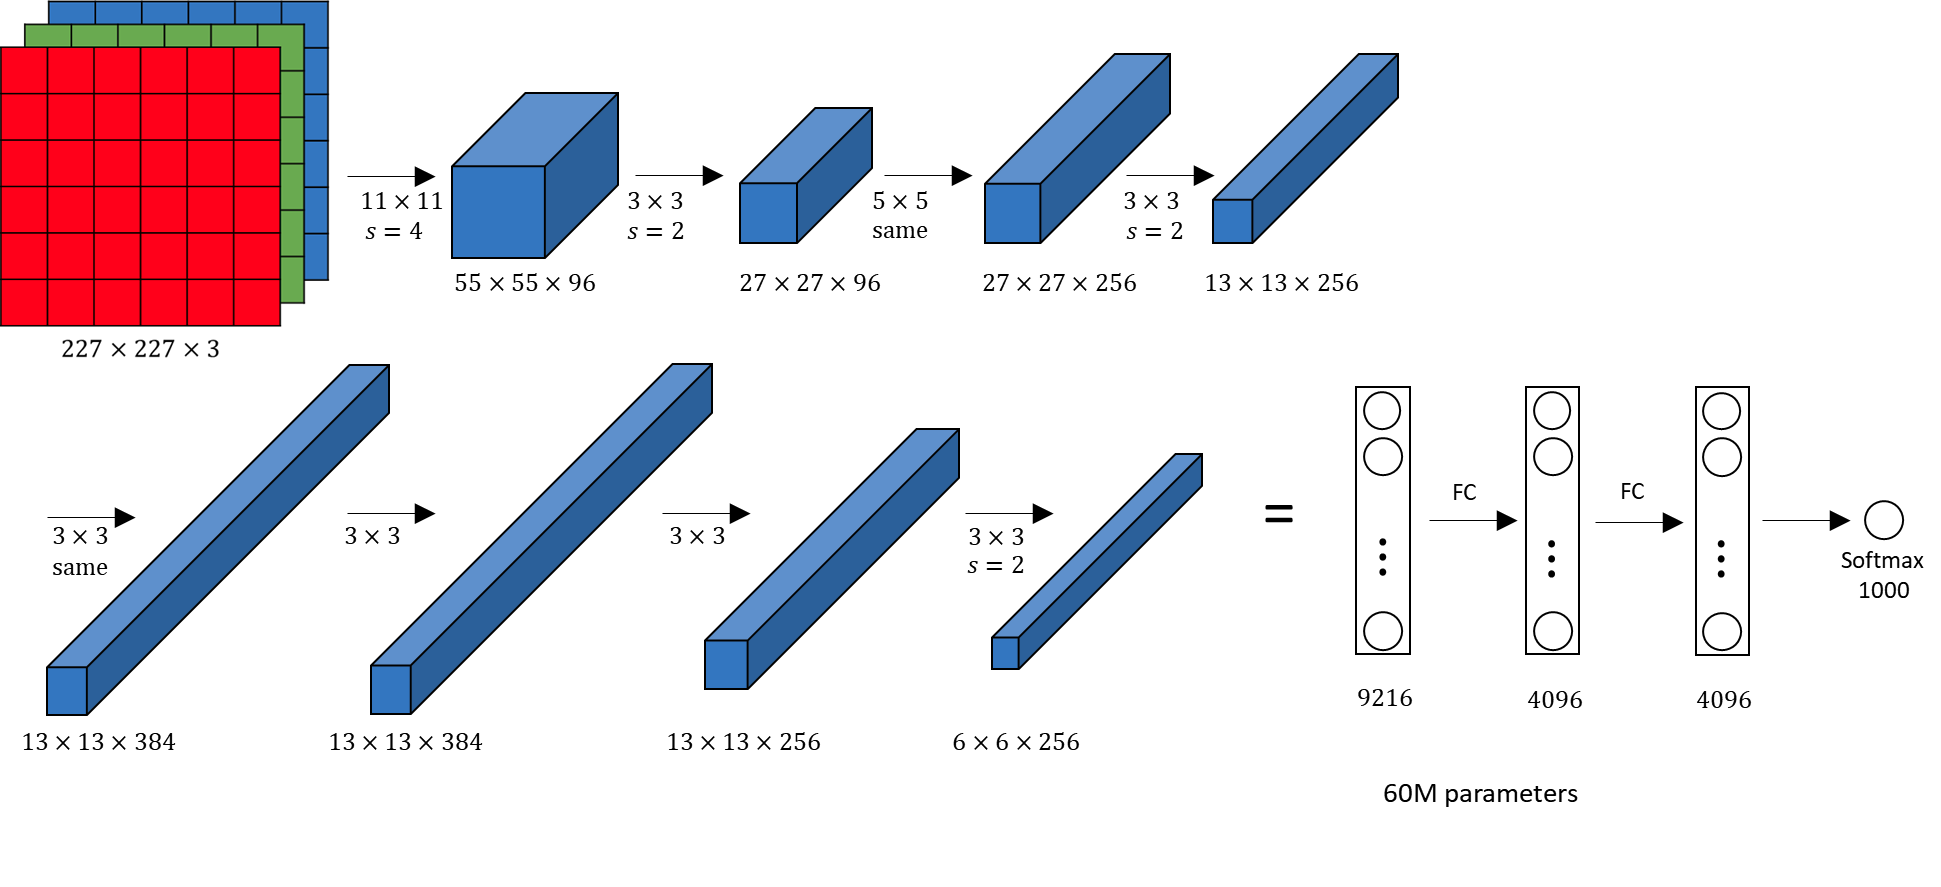


In [77]:
import torchvision.models as models
alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [78]:
def plot_weights_alexnet(model):
  
  #extracting the model features at the particular layer number
  layer = model.features[0]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.features[0].weight.data        
    if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
    else:
        print("Can only plot weights with three channels with single channel = False")

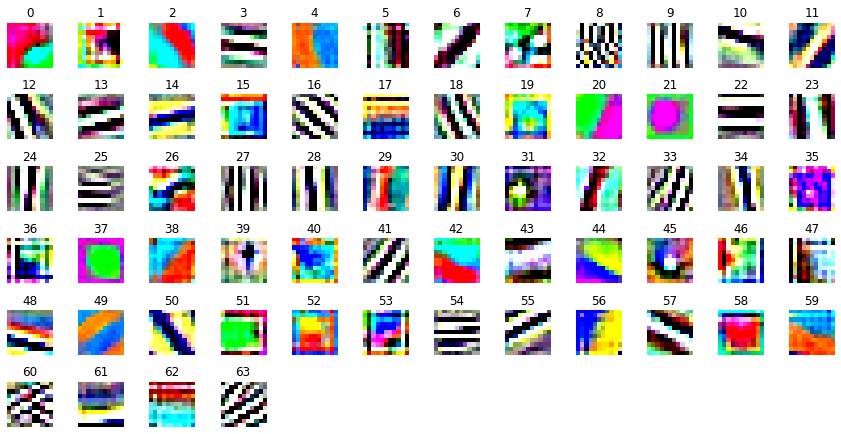

In [79]:
plot_weights_alexnet(alexnet)

Lets see how receptive fields and feature mapping work hand in hand. 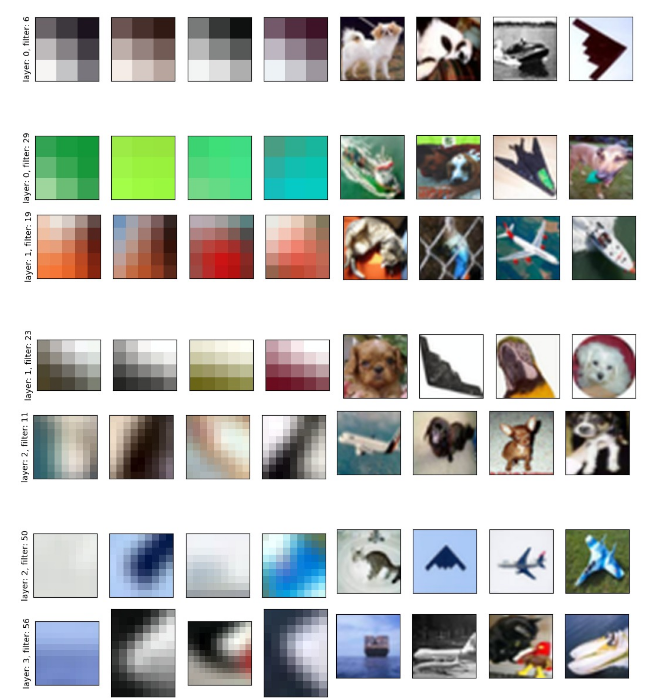